In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

## Load data

In [2]:
def get_data():
    
    try:
        columns = np.load("data_columns.npy")
        X = np.load("data_arousal_physio_for_svm.npy")
        Y = np.load("data_arousal_label_for_svm.npy")
        return pd.DataFrame(X, columns=columns), pd.DataFrame(Y)
    except:
        print "No stored files found.. load from files first"

In [3]:
X, Y = get_data()
print X.shape
print Y.shape

(321600, 24)
(321600, 1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc441354110>]],
      dtype=object)

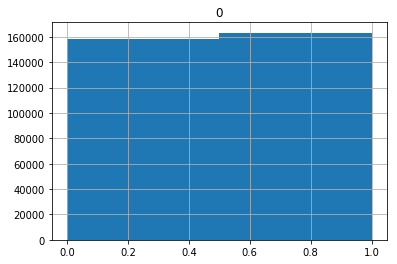

In [4]:
# binarize the problem
Y[Y<=4] = 0
Y[Y>=5] = 1
Y.hist(bins=2)

In [5]:
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def add_interactions(df):
    # Get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    
    # Find interactions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    # Remove interaction terms with all 0 values            
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis=1)
    
    return df

In [6]:
x_interact = add_interactions(pd.DataFrame(X))
print(x_interact.head(5))

   ECG_mean   ECG_std   ECG_min   ECG_max  ECG_mean_diff  ECG_mean_abs_diff  \
0  0.479928  0.836233  0.762411  0.847555       0.143484           0.735903   
1  0.494200  0.837120  0.790508  0.847555       0.149529           0.729567   
2  0.509006  0.838540  0.816535  0.847555       0.148153           0.718838   
3  0.524329  0.840444  0.844597  0.847555       0.140240           0.700898   
4  0.540185  0.842825  0.870634  0.847555       0.135463           0.685053   

   EDA_mean   EDA_std  EDA_min   EDA_max  ...  SKT_std_SKT_min  \
0  0.000079  0.052617      0.0  0.003736  ...         0.001161   
1  0.000124  0.051788      0.0  0.003329  ...         0.001254   
2  0.000179  0.050956      0.0  0.002930  ...         0.001156   
3  0.000243  0.050122      0.0  0.002538  ...         0.001248   
4  0.000317  0.049288      0.0  0.002154  ...         0.001151   

   SKT_std_SKT_max  SKT_std_SKT_mean_diff  SKT_std_SKT_mean_abs_diff  \
0         0.000402               0.009700               

## Create train and test set

In [7]:
xtrain, xval, ytrain, yval = train_test_split(x_interact, Y, test_size=.2, shuffle=False)
print xtrain.shape
print ytrain.shape
print xval.shape
print yval.shape

(257280, 300)
(257280, 1)
(64320, 300)
(64320, 1)


In [8]:
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import RFECV

## LinearSVC train and test

In [9]:
lsvc = LinearSVC(C=1, tol=1e-4, dual=False, fit_intercept=True, class_weight='balanced', verbose=True)
lsvc.fit(xtrain, ytrain.values.ravel())
lsvc.score(xval, yval.values.ravel())

[LibLinear]

0.5097481343283582

## KBest Feature selection + SVC

In [10]:
# Such a large set of features can cause overfitting and also slow computing
# Use feature selection to select the most important features
import sklearn.feature_selection

In [11]:
scores_by_kbest = []

for k in range(1,50):

    kbest_selector = sklearn.feature_selection.SelectKBest(k=k)
    kbest_selector.fit(xtrain, ytrain)
    
    lsvc = LinearSVC(C=1, tol=1e-4, dual=False, fit_intercept=True, class_weight='balanced', verbose=True)
    lsvc.fit(kbest_selector.transform(xtrain), ytrain.values.ravel())
    score = lsvc.score(kbest_selector.transform(xval), yval.values.ravel())

    ks = {
        "feature" : xtrain.columns[kbest_selector.get_support()],
        "score" : score
    }
    
    scores_by_kbest.append(ks)

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

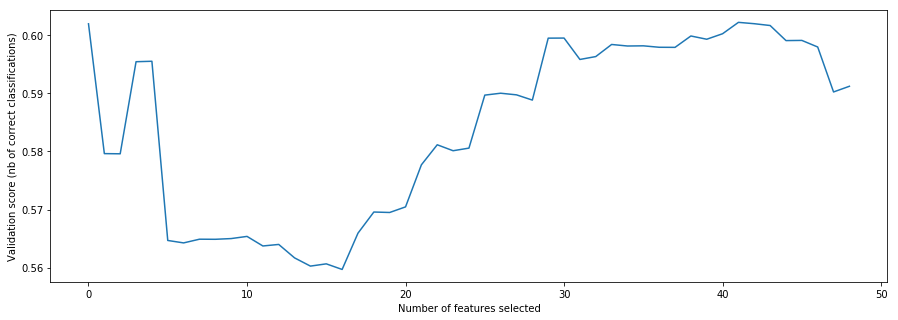

In [12]:
scores = [ s["score"] for s in scores_by_kbest ]
plt.figure(figsize=(15,5))
plt.xlabel("Number of features selected")
plt.ylabel("Validation score (nb of correct classifications)")
plt.plot(np.arange(len(scores)), scores)
plt.show()

In [13]:
max_score = max(scores_by_kbest, key=lambda x: x["score"])
print max_score["feature"]
print max_score["score"]

Index([u'ECG_mean_diff', u'EDA_mean_diff', u'ECG_mean_ECG_mean_diff',
       u'ECG_mean_EDA_mean', u'ECG_mean_EDA_min', u'ECG_mean_EDA_max',
       u'ECG_mean_EDA_mean_abs_diff', u'ECG_min_ECG_mean_diff',
       u'ECG_min_EDA_mean', u'ECG_min_EDA_min', u'ECG_min_EDA_max',
       u'ECG_min_EDA_mean_abs_diff', u'ECG_max_EDA_mean', u'ECG_max_EDA_min',
       u'ECG_mean_diff_EDA_mean', u'ECG_mean_diff_EDA_std',
       u'ECG_mean_diff_EDA_min', u'ECG_mean_diff_EDA_max',
       u'ECG_mean_diff_EDA_mean_diff', u'ECG_mean_diff_EDA_mean_abs_diff',
       u'ECG_mean_diff_Resp_mean', u'ECG_mean_diff_Resp_std',
       u'ECG_mean_diff_Resp_min', u'ECG_mean_diff_Resp_max',
       u'ECG_mean_diff_Resp_mean_diff', u'ECG_mean_diff_Resp_mean_abs_diff',
       u'ECG_mean_abs_diff_EDA_mean', u'ECG_mean_abs_diff_EDA_min',
       u'EDA_mean_EDA_max', u'EDA_mean_EDA_mean_diff', u'EDA_mean_Resp_std',
       u'EDA_mean_Resp_max', u'EDA_mean_Resp_mean_abs_diff',
       u'EDA_min_Resp_max', u'EDA_min_Resp_mean_a

## Univariate Feature Selection + SVC

In [14]:
from sklearn.feature_selection import SelectPercentile, f_classif

In [15]:
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(xtrain, ytrain)

SelectPercentile(percentile=10,
         score_func=<function f_classif at 0x7fc4453117d0>)

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


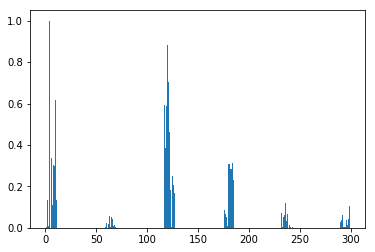

Index([u'ECG_mean_diff', u'EDA_mean_diff', u'ECG_mean_ECG_mean_diff',
       u'ECG_mean_EDA_mean', u'ECG_mean_EDA_min', u'ECG_mean_EDA_max',
       u'ECG_min_ECG_mean_diff', u'ECG_min_EDA_mean', u'ECG_min_EDA_min',
       u'ECG_min_EDA_max', u'ECG_max_EDA_mean', u'ECG_max_EDA_min',
       u'ECG_mean_diff_EDA_mean', u'ECG_mean_diff_EDA_std',
       u'ECG_mean_diff_EDA_min', u'ECG_mean_diff_EDA_max',
       u'ECG_mean_diff_EDA_mean_diff', u'ECG_mean_diff_EDA_mean_abs_diff',
       u'ECG_mean_diff_Resp_mean', u'ECG_mean_diff_Resp_min',
       u'ECG_mean_diff_Resp_max', u'ECG_mean_diff_Resp_mean_diff',
       u'ECG_mean_diff_Resp_mean_abs_diff', u'EDA_mean_Resp_max',
       u'EDA_mean_Resp_mean_abs_diff', u'EDA_max_EDA_mean_diff',
       u'EDA_mean_diff_Resp_mean', u'EDA_mean_diff_Resp_min',
       u'EDA_mean_diff_Resp_max', u'EDA_mean_diff_Resp_mean_diff'],
      dtype='object')

In [16]:
scores = -np.log10(selector.pvalues_)
scores[np.isinf(scores)] = scores[np.isfinite(scores)].max()
scores /= scores.max()
plt.bar(np.arange(x_interact.shape[1]), scores, width=.2)
plt.show()

x_interact.columns[selector.get_support()]

In [17]:
lsvc = LinearSVC(C=1, tol=1e-4, dual=False, fit_intercept=True, class_weight='balanced', verbose=True)
lsvc.fit(selector.transform(xtrain), ytrain.values.ravel())
lsvc.score(selector.transform(xval), yval)

[LibLinear]

0.5995180348258706

## Recursive feature selection

In [18]:
lsvc = LinearSVC(C=1, tol=1e-4, dual=False, fit_intercept=True, class_weight='balanced')
rfecv = RFECV(estimator=lsvc, step=10, cv=3, scoring='accuracy', n_jobs=-1)

In [19]:
rfecv.fit(xtrain, ytrain.values.ravel())
rfecv.score(xval, yval.values.ravel())

0.5282804726368159

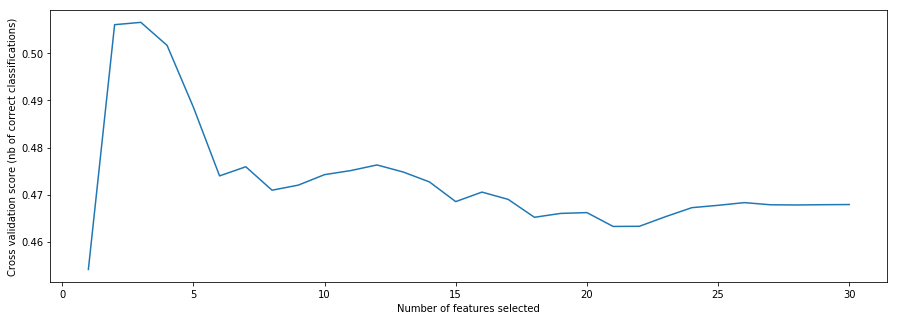

In [20]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_[:30]) + 1), rfecv.grid_scores_[:30])
plt.show()